**Занятие № 4 Обработка текстов с помощью нейронных сетей.**

**Классификация текстов**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [39]:
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, SpatialDropout1D, Embedding, Flatten, Activation, Conv1D
from keras.optimizers import Adam, RMSprop, Adadelta
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import time

In [3]:
from keras.layers import BatchNormalization

**Загурка данных**

In [4]:
def readText(fileName):
    f = open(fileName, "r", encoding='utf-8')
    text = f.read()
    text = text.replace("\n", " ")

    return text

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"]
nclasses = len(className)

In [ ]:
base_path = r"Тексты писателей"

In [6]:
trainText = []
testText = []

""" 
Форматирование необходимо провести следующим образом:
класс каждого i-того элемента в обучающей выборке должен соответсвовать классу каждого 
i-того элемента в тестовой выборке
"""
for i in className:
    
    # Проходим по всем файлам в папке
    for filename in os.listdir(base_path):
        file_path = os.path.join(base_path, filename)
        
        # Проверяем, что файл принадлежит текущему автору
        if i in filename:
            if "Обучающая" in filename:
                trainText.append(readText(file_path))
                print(filename, "добавлен в обучающую выборку", i)
            elif "Тестовая" in filename:
                testText.append(readText(file_path))
                print(filename, "добавлен в тестовую выборку", i)
    print()

(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку О. Генри
(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку О. Генри

(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку Стругацкие
(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку Стругацкие

(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку Булгаков
(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку Булгаков

(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку Саймак
(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку Саймак

(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку Фрай
(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку Фрай

(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку Брэдберри
(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку Брэдберри



In [7]:
print(len(trainText))  # Количество элементов (классов)
print(len(trainText[0]))  # Количество симфолов в 1 источнике

6
1049517


In [ ]:
# trainText[0] 
# Очень длинный фрагмент.

**Обработка данных. Преобразование текстовых данных в числовые и векторные для обучения НС**

In [9]:
cur_time = time.time()  # Засекаем время

# Словарь частотности
maxWordsCount = 20000  # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

"""
Воспользуемся встроенной функцией tokenizer для разбиения текста и превращения в матрицу 
числовых значений:
num_words = maxWordsCount - Определяем максимальное количество слов/индексов, учитываемое при обучении текста
filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
lower = True - приводим слова к нижнему регистру
split = ' ' - разделяем слова по пробелу
char_Level = False - просим токинайзер не удалять однобуквенные слова
символ U+FEFF (Zero Width No-Break Space, он же BOM), можно записать как \ufeff
Средний прочерк (эн-дэш, "–"): Windows: Alt + 0150 (на цифровой клавиатуре)
Длинный прочерк (эм-дэш, "—"): Windows: Alt + 0151 (на цифровой клавиатуре)
Кавычки «ёлочки» Windows:
                Alt + 0171 → «
                Alt + 0187 → »
"""

tokenizer = Tokenizer(num_words=maxWordsCount,
                      filters='!"#$%&()*+,-–—./...:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True,
                      split=' ', 
                      oov_token='unknown',
                      char_level=False)

tokenizer.fit_on_texts(trainText)  # направляем тексты на обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items())  # Вытаскиваем индексы слов для просмотра
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

Время обработки: 2.78c


In [10]:
print(items[-10:])  # Посмотрим 50 самых часто встречающихся слов
print('Длина словаря: ', len(items))

[('заполните', 139020), ('мучающие', 139021), ('погремушкой', 139022), ('свистком', 139023), ('потерян', 139024), ('расплывающиеся', 139025), ('миллионе', 139026), ('разрыв…', 139027), ('зияющая', 139028), ('ничтонавстречу', 139029)]
Длина словаря:  139029


In [ ]:
tokenizer.word_index

In [ ]:
tokenizer.index_word

In [13]:
print('Интересующее слово имеет индекс: ', tokenizer.word_index[input("Уточните слово: ")])
# слово пошел

Интересующее слово имеет индекс:  356


In [14]:
# преобразуем текст в последовательность индексов согласно частотному словарю
trainWordIndex = tokenizer.texts_to_sequences(trainText)  # обучающие тексты в индексы
testWordIndex = tokenizer.texts_to_sequences(testText)  # Проверочные тексты в индексы

print("Взглянем на фрагмент обучающего текста")
print("В виде оригинального текста                 :", trainText[1][:87])
print("Он же, но в виде последовательности индексов: ", trainWordIndex[1][:20], '\n')

Взглянем на фрагмент обучающего текста
В виде оригинального текста                 : Парень из преисподней     1     Ну и деревня! Сроду я таких деревень не видел и не знал
Он же, но в виде последовательности индексов:  [472, 22, 1, 1488, 47, 2, 12785, 7761, 5, 415, 1, 4, 252, 2, 4, 248, 55, 6, 240, 10564] 



In [15]:
print("Статистика по обучающим текстам:")

symbolstrainText = 0
wordsTrainText = 0

for i in range(nclasses):
    print(className[i], " "*(10-len(className[i])), len(trainText[i]), " символов, ", len(trainWordIndex[i]), "слов")
    symbolstrainText += len(trainText[i])  # считаем символы
    wordsTrainText += len(trainWordIndex[i])  # считаем слова

print('--------')
print("В сумме ", symbolstrainText, " символов, ", wordsTrainText, " слов \n")
print()
print("Статистика по тестовым текстам:")

symbolsTestText = 0
wordsTestText = 0

for i in range(nclasses):
    print(className[i], " "*(10-len(className[i])), len(testText[i]), " символов, ", len(testWordIndex[i]), "слов")
    symbolsTestText += len(testText[i])  # считаем символы
    wordsTestText += len(testWordIndex[i])  # считаем слова

print('--------')
print("В сумме ", symbolsTestText, " символов, ", wordsTestText, " слов \n")


Статистика по обучающим текстам:
О. Генри    1049517  символов,  160611 слов
Стругацкие  2042469  символов,  313044 слов
Булгаков    1765648  символов,  261654 слов
Саймак      1609507  символов,  251505 слов
Фрай        3700010  символов,  568584 слов
Брэдберри   1386454  символов,  214472 слов
--------
В сумме  11553605  символов,  1769870  слов 


Статистика по тестовым текстам:
О. Генри    349662  символов,  53240 слов
Стругацкие  704846  символов,  108646 слов
Булгаков    875042  символов,  132733 слов
Саймак      318811  символов,  50360 слов
Фрай        1278191  символов,  196738 слов
Брэдберри   868673  символов,  132531 слов
--------
В сумме  4395225  символов,  674248  слов 



**Создание обучающей выборки**

Функции для формирования выборки по отрезкам текста с заданным шагом

In [16]:
# Формируем обучающую выборку по листу индексов слов (разделение на короткие вектора)
def getSetFromIndexes(wordIndexes, xlen, step):  # Последовательность индексов, размер окна, шаг окна
    xSample = []
    wordsLen = len(wordIndexes)
    index = 0

    while (index + xlen <= wordsLen):
        xSample.append(wordIndexes[index:index+xlen])  # отрываем вектор длины xlen
        index += step

    return xSample

In [17]:
# Формируем обучающую и проверочную выборку из двух листов индексов слов от двух классов
def createSetsMultiClasses(wordIndexes, xlen, step):  # Последовательность индексов, размер окна, шаг окна
    
    # Для каждого из 6 классов
    nClasses = len(wordIndexes)
    classesXSamples = []

    for wI in wordIndexes:
        classesXSamples.append(getSetFromIndexes(wI, xlen, step))

    # формируем один общий Sample
    xSamles = []
    ySamples = []

    for t in range(nClasses):
        xT = classesXSamples[t]
        for i in range(len(xT)):
            xSamles.append(xT[i])
            ySamples.append(utils.to_categorical(t, nClasses))

    xSamles = np.array(xSamles)
    ySamples = np.array(ySamples)

    return (xSamles, ySamples)  # Возвращаем выборку и соответствующие вектора классов

In [46]:
def create_train_data(maxWordsCount=15000, xlen=1000, step=100):
    """
    Создает обучающую выборку из текстов писателей
    maxWordsCount - максимальное количество слов/индексов, учитываемое при обучении текстов
    xlen - размер окна (длина вектора)
    step - шаг окна
    """
    tokenizer = Tokenizer(num_words=maxWordsCount)
    tokenizer.fit_on_texts(trainText)  # направляем тексты на обработку методу, который соберет словарь частотности
    
    trainWordIndex = tokenizer.texts_to_sequences(trainText)  # обучающие тексты
    testWordIndex = tokenizer.texts_to_sequences(testText)  # Проверочные тексты
    
    # Формируем обучающую выборку из двух листов индексов слов от двух классов
    xTrain, yTrain = createSetsMultiClasses(trainWordIndex, xlen, step)
    
    # Формируем проверочную выборку из двух листов индексов слов от двух классов
    xTest, yTest = createSetsMultiClasses(testWordIndex, xlen, step)

    return xTrain, xTrain01, yTrain, xTest, xTest01, yTest  # Возвращаем выборки и соответствующие вектора классов

**Подготовка данных**

In [18]:
# Создаем базовые параметры
xLen = 1000 # Длина отрезка текста, по которым анализируем, в словах
step = 100  # Шаг разбиения исходного текста на обучающие векторы

In [19]:
cur_time = time.time()

xTrain, yTrain = createSetsMultiClasses(trainWordIndex, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndex, xLen, step)

print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(17642, 1000)
(17642, 6)
(6686, 1000)
(6686, 6)
Время обработки: 2.08c


In [ ]:
print(xTrain[0])

**Обратное преобразование**

In [ ]:
# Обратное преобразование
tokenizer.sequences_to_texts([xTrain[0]])

In [ ]:
# сдвинем на 100 слов
tokenizer.sequences_to_texts([xTrain[0][100:]])

In [ ]:
# Получим тот же текст без сдвига
tokenizer.sequences_to_texts([xTrain[1]])

**Получим Bag of words из токетов**

In [24]:
cur_time = time.time()
# Сначала делим, а потом преобразуем последовательности в векторы
# Преобразуем полученные выборки из последователльных индексов в матрицы нудей и едениц
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist())  # Подаем в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())

print(xTrain01.shape)
print(xTrain01[0][0:100])

print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(17642, 20000)
[0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 1. 1.]
Время обработки: 9.73c


In [ ]:
for i in range(100):
    print(int(i in xTrain[0]), end=' ')

**Нейросеть**

Epoch 1/10
138/138 [==============================] - 4s 26ms/step - loss: 0.0472 - accuracy: 0.9858 - val_loss: 0.3672 - val_accuracy: 0.9134
Epoch 2/10
138/138 [==============================] - 3s 21ms/step - loss: 3.4656e-04 - accuracy: 1.0000 - val_loss: 0.3174 - val_accuracy: 0.9076
Epoch 3/10
138/138 [==============================] - 3s 19ms/step - loss: 1.7622e-04 - accuracy: 1.0000 - val_loss: 0.3092 - val_accuracy: 0.9020
Epoch 4/10
138/138 [==============================] - 3s 19ms/step - loss: 1.0895e-04 - accuracy: 1.0000 - val_loss: 0.3135 - val_accuracy: 0.8981
Epoch 5/10
138/138 [==============================] - 3s 19ms/step - loss: 7.1664e-05 - accuracy: 1.0000 - val_loss: 0.3083 - val_accuracy: 0.9007
Epoch 6/10
138/138 [==============================] - 3s 19ms/step - loss: 5.3883e-05 - accuracy: 1.0000 - val_loss: 0.3092 - val_accuracy: 0.9013
Epoch 7/10
138/138 [==============================] - 3s 19ms/step - loss: 4.2886e-05 - accuracy: 1.0000 - val_loss: 0.306

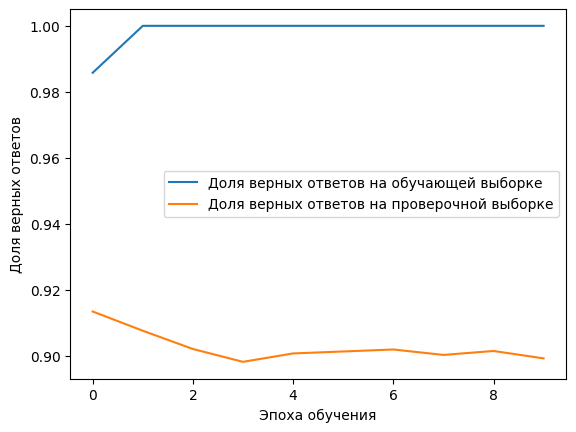

In [26]:
model01 = Sequential()
model01.add(Dense(200, input_dim=maxWordsCount, activation='relu'))
model01.add(Dropout(0.25))
model01.add(BatchNormalization())
model01.add(Dense(6, activation='softmax'))  # У нас 6 писателей

model01.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history = model01.fit(xTrain01, yTrain,
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающей выборке')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочной выборке')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Наша нейронная сеть определяет автора с точностью 89%

**Распознование проверочной выборки**

In [27]:
# представляем тестовую выборку в удобных для распознования размерах
def createTetestMultiClasses(wordIndexes, xLen, step):
    """Для каждого из 6 классов  создаем тестовую выборку из индексов"""
    nClasses = len(wordIndexes)  # Задаем количество классов
    xTest6Classes01 = []  #  для списка классов, каждый размером 20000
    xTest6Classes = []  # Для списка массивов, каждый размером в длину окна (6 по 420*1000)

    for wI in wordIndexes:
        sample = getSetFromIndexes(wI, xLen, step)
        xTest6Classes.append(sample)
        xTest6Classes01.append(tokenizer.sequences_to_matrix(sample))
    xTest6Classes01 = np.array(xTest6Classes01, dtype=object)
    xTest6Classes = np.array(xTest6Classes, dtype=object)

    return xTest6Classes01, xTest6Classes

In [28]:
# Распознаем тестовую выборку и выводим результат
def recognizeMultiClass(model, xTest, modelName):
    print('Нейронка: ', modelName)
    print()

    totalSumRec = 0

    for i in range(nclasses):
        # Пролучаем результаты распознования класса по блокам слов длины xLen
        currPred = model.predict(xTest[i])

        # Определяем номер распознанного класса для каждого блока слов длиной xLen
        currOut = np.argmax(currPred, axis=1)

        evVal = []
        for j in range(nclasses):
            evVal.append(len(currOut[currOut==j])/len(xTest[i]))

        totalSumRec += len(currOut[currOut==i])
        recognizedClass = np.argmax(evVal)  # определяем, какой класс был распознан

        isRecognized = 'Это НЕПРАВИЛЬНЫЙ ответ'
        if recognizedClass == i:
            isRecognized = 'Это Правильный ответ'

        str1 = f"Класс: {className[i]}{' ' * (11 - len(className[i]))}{int(100 * evVal[i])}% сеть отнесла к классу {className[recognizedClass]}"
        print(str1 + ' ' * (55 - len(str1)), isRecognized)

    # Выводим средний % распознования по всем классам вместе
    print()
    sumCount = 0
    for i in range(nclasses):
        sumCount += len(xTest[i])
    print('Средний процент распознования ', int(100*totalSumRec/sumCount), '%', sep='')
    print()

    return totalSumRec/sumCount

In [29]:
# Преобразуем тестовую выборку
xTest6Classes01, x2 = createTetestMultiClasses(testWordIndex, xLen, step)

In [30]:
l = np.array(xTest6Classes01)
np.save(r'C:\Users\mmd28\OneDrive\Рабочий стол\Scripts_Нейронные сети\Нейронные сети Университет ИИ\xTestPredictBow', l)
np.save(r'C:\Users\mmd28\OneDrive\Рабочий стол\Scripts_Нейронные сети\Нейронные сети Университет ИИ\xTestPredictEmbedding', x2)

In [31]:
# Проверим точность нейронки обученной на bag of words
perd = recognizeMultiClass(model01, xTest6Classes01, 'Тексты 01 + Dense')

Нейронка:  Тексты 01 + Dense

17/17 [==============================] - 0s 3ms/step
Класс: О. Генри   94% сеть отнесла к классу О. Генри    Это Правильный ответ
34/34 [==============================] - 0s 4ms/step
Класс: Стругацкие 87% сеть отнесла к классу Стругацкие  Это Правильный ответ
42/42 [==============================] - 0s 3ms/step
Класс: Булгаков   81% сеть отнесла к классу Булгаков    Это Правильный ответ
16/16 [==============================] - 0s 4ms/step
Класс: Саймак     85% сеть отнесла к классу Саймак      Это Правильный ответ
62/62 [==============================] - 0s 4ms/step
Класс: Фрай       91% сеть отнесла к классу Фрай        Это Правильный ответ
42/42 [==============================] - 0s 4ms/step
Класс: Брэдберри  98% сеть отнесла к классу Брэдберри   Это Правильный ответ

Средний процент распознования 89%



**Embedding + Dense**

In [32]:
modelE = Sequential()
modelE.add(Embedding(maxWordsCount, 20, input_length=xLen))  # параметры: размер словаря, размер пространства и входная длинна

modelE.add(SpatialDropout1D(0.2))  # Отключет целую ось пространства
modelE.add(Flatten())
modelE.add(BatchNormalization())

modelE.add(Dense(200, activation='relu'))
modelE.add(Dropout(0.2))
modelE.add(BatchNormalization())
modelE.add(Dense(6, activation='softmax'))  # У нас 6 писателей

modelE.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [33]:
modelE.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 20)          400000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 1000, 20)         0         
 ropout1D)                                                       
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 batch_normalization_1 (Batc  (None, 20000)            80000     
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 200)               4000200   
                                                                 
 dropout_1 (Dropout)         (None, 200)              

Epoch 1/10


138/138 [==============================] - 7s 48ms/step - loss: 0.8387 - accuracy: 0.7346 - val_loss: 1.6905 - val_accuracy: 0.3753
Epoch 2/10
138/138 [==============================] - 7s 48ms/step - loss: 0.0152 - accuracy: 0.9988 - val_loss: 1.4471 - val_accuracy: 0.4236
Epoch 3/10
138/138 [==============================] - 6s 46ms/step - loss: 0.0070 - accuracy: 0.9995 - val_loss: 1.1678 - val_accuracy: 0.5401
Epoch 4/10
138/138 [==============================] - 6s 46ms/step - loss: 0.0051 - accuracy: 0.9997 - val_loss: 0.8954 - val_accuracy: 0.6653
Epoch 5/10
138/138 [==============================] - 6s 47ms/step - loss: 0.0032 - accuracy: 0.9997 - val_loss: 0.7947 - val_accuracy: 0.7119
Epoch 6/10
138/138 [==============================] - 7s 47ms/step - loss: 0.0023 - accuracy: 0.9998 - val_loss: 0.8342 - val_accuracy: 0.6991
Epoch 7/10
138/138 [==============================] - 6s 47ms/step - loss: 0.0018 - accuracy: 0.9999 - val_loss: 0.8602 - val_accuracy: 0.6910
Epoch 8/10

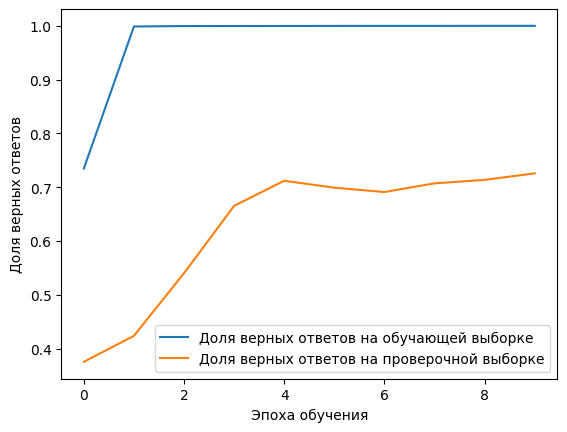

In [34]:
history = modelE.fit(xTrain, yTrain,
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest, yTest))

plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающей выборке')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочной выборке')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [35]:
modelE.save_weights('model 1.h5')

In [36]:
modelE.load_weights("model 1.h5")

In [37]:
# Проверяем результаты работы
_, xTest6Classes = createTetestMultiClasses(testWordIndex, xLen, step)
pred = recognizeMultiClass(modelE, xTest6Classes, "Embedding + dense")

Нейронка:  Embedding + dense

17/17 [==============================] - 0s 4ms/step
Класс: О. Генри   68% сеть отнесла к классу О. Генри    Это Правильный ответ
34/34 [==============================] - 0s 4ms/step
Класс: Стругацкие 74% сеть отнесла к классу Стругацкие  Это Правильный ответ
42/42 [==============================] - 0s 5ms/step
Класс: Булгаков   60% сеть отнесла к классу Булгаков    Это Правильный ответ
16/16 [==============================] - 0s 4ms/step
Класс: Саймак     53% сеть отнесла к классу Саймак      Это Правильный ответ
62/62 [==============================] - 0s 4ms/step
Класс: Фрай       85% сеть отнесла к классу Фрай        Это Правильный ответ
42/42 [==============================] - 0s 4ms/step
Класс: Брэдберри  72% сеть отнесла к классу Брэдберри   Это Правильный ответ

Средний процент распознования 72%



In [1]:
import gc
gc.collect()  # чистим оперативную память

10